## Setting up **Spark**

###Adding the floating License

In [ ]:
import json
import os

from google.colab import files

if 'spark_nlp_for_healthcare_spark_ocr_9813.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_nlp_for_healthcare_spark_ocr_9813.json')

with open('spark_nlp_for_healthcare_spark_ocr_9813.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [ ]:
license_keys.keys()

dict_keys(['SPARK_NLP_LICENSE', 'SECRET', 'JSL_VERSION', 'SPARK_OCR_LICENSE', 'SPARK_OCR_SECRET', 'OCR_VERSION', 'PUBLIC_VERSION', 'AWS_ACCESS_KEY_ID', 'AWS_SECRET_ACCESS_KEY', 'AWS_SESSION_TOKEN'])

In [ ]:
license_keys['JSL_VERSION']

'5.5.1'

In [ ]:
license_keys['PUBLIC_VERSION']

'5.5.1'

### Installing Spark

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.4.1 spark-nlp==$PUBLIC_VERSION


# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.6/626.6 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.9/538.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.0 MB/s eta 0:00:00


###Configuring Spark environment and starting Spark

In [ ]:
#Setting up spark
import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp_jsl.pipeline_tracer import PipelineTracer
from sparknlp_jsl.pipeline_output_parser import PipelineOutputParser

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

import pandas as pd
pd.set_option('display.max_colwidth', 200)

from pyspark.sql.functions import col, explode, lit

from tqdm import tqdm
from collections import Counter
from sparknlp.training import CoNLL

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"10G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

spark

Spark NLP Version : 5.5.1
Spark NLP_JSL Version : 5.5.1


##Dataset Selection

###Creating and formatting DataFrame

In [ ]:
#Loading the data in a DataFrame
folder_path = '/content/onc_notes'
mt_samples_df = spark.read.text(os.path.join(folder_path, "*.txt"), wholetext=True)
mt_samples_df = mt_samples_df.withColumnRenamed("value", "text")

# Adding the index to df
from pyspark.sql.window import Window
mt_samples_df = mt_samples_df.withColumn("index",
    F.row_number().over(Window.orderBy(F.lit(1))))

#Moving the index to the left side
mt_samples_df.select("index", "text").show(10, truncate=True)
mt_samples_df = mt_samples_df.select("index", "text")

+-----+--------------------+
|index|                text|
+-----+--------------------+
|    1|Sample Type / Med...|
|    2|Sample Type / Med...|
|    3|Sample Type / Med...|
|    4|Sample Type / Med...|
|    5|Sample Type / Med...|
|    6|Sample Type / Med...|
|    7|Sample Type / Med...|
|    8|Sample Type / Med...|
|    9|Sample Type / Med...|
|   10|Sample Type / Med...|
+-----+--------------------+



###Data Frame Schema and sample

In [ ]:
#Show the schema of the DataFrame
mt_samples_df.printSchema()

root
 |-- index: integer (nullable = false)
 |-- text: string (nullable = true)



In [ ]:
#Display the contents of the DataFrame
mt_samples_df.show()

+-----+--------------------+
|index|                text|
+-----+--------------------+
|    1|Sample Type / Med...|
|    2|Sample Type / Med...|
|    3|Sample Type / Med...|
|    4|Sample Type / Med...|
|    5|Sample Type / Med...|
|    6|Sample Type / Med...|
|    7|Sample Type / Med...|
|    8|Sample Type / Med...|
|    9|Sample Type / Med...|
|   10|Sample Type / Med...|
+-----+--------------------+



In [ ]:
#Print the first row of the DataFrame
print(mt_samples_df.limit(5).collect()[0]['text'])

Sample Type / Medical Specialty:
Hematology - Oncology
Sample Name:
Consult - Breast Cancer
Description:
Patient presents with complaint of lump in the upper outer quadrant of the right breast
(Medical Transcription Sample Report)
CHIEF COMPLAINT / REASON FOR THE VISIT:
Patient has been diagnosed to have breast cancer.
BREAST CANCER HISTORY:
Patient presented with the following complaints: Lump in the upper outer quadrant of the right breast that has been present for the last 4 weeks. The lump is painless and the skin over the lump is normal. Patient denies any redness, warmth, edema and nipple discharge. Patient had a mammogram recently and was told to have a mass measuring 2 cm in the UOQ and of the left breast. Patient had an excisional biopsy of the mass and subsequently axillary nodal sampling.
PATHOLOGY:
Infiltrating ductal carcinoma, Estrogen receptor 56, Progesterone receptor 23, S-phase fraction 2., Her 2 neu 0 and all nodes negative.
STAGE:
Stage I.
TNM STAGE:
T1, N0 and M0.


## NER pipeline execution

###Multimodel NER Pipeline(Pretrained) - Merged

In [ ]:
# Document Assembler
documentAssembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol("document")

# Sentence Detector
sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare", "en", "clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Tokenizer
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Clinical Word Embeddings
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

# NER Models
# NER Model for clinical
clinical_ner = MedicalNerModel.pretrained("ner_clinical_large", "en", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")\
    .setLabelCasing("upper")

# NER model for de-identification
deid_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner_deid")

# NER model for posology (medication-related entities)
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner_posology")

# Converter for Clinical NER
clinical_ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol('ner_chunk_clinical')

# Converter for deid NER
deid_ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_deid"])\
    .setOutputCol("ner_chunk_deid")

# Converter for posology NER
posology_ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_posology"])\
    .setOutputCol("ner_chunk_posology")

#Merging the 3 models and prioritising posology and deid
chunk_merge = ChunkMergeApproach()\
    .setInputCols("ner_chunk_posology","ner_chunk_deid","ner_chunk_clinical")\
    .setOutputCol("merged_chunk")\
    .setOrderingFeatures(["ChunkLength"])\
    .setSelectionStrategy("DiverseLonger")\
    .setCaseSensitive(False)


# Create the pipeline
pipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    deid_ner,
    posology_ner,
    clinical_ner_converter,
    deid_ner_converter,
    posology_ner_converter,
    chunk_merge
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)
light_model = LightPipeline(model)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical_large download started this may take some time.
[OK!]
ner_deid_generic_augmented download started this may take some time.
[OK!]
ner_posology download started this may take some time.
[OK!]


###Pipeline Verification

In [ ]:
# Verify the model stages
model.stages

[DocumentAssembler_3d405e760573,
 SentenceDetectorDLModel_6bafc4746ea5,
 REGEX_TOKENIZER_e133f9295ac1,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_1a8637089929,
 MedicalNerModel_e8178a1262cc,
 MedicalNerModel_4a303d875127,
 NER_CONVERTER_700e25d2a62c,
 NER_CONVERTER_92d933bd3c74,
 NER_CONVERTER_565743357e24,
 MERGE_79803ac89c6d]

In [ ]:
# Get classes/labels for each NER model
clinical_ner.getClasses()
deid_ner.getClasses()
posology_ner.getClasses()

['O',
 'B-DOSAGE',
 'B-STRENGTH',
 'I-STRENGTH',
 'B-ROUTE',
 'B-FREQUENCY',
 'I-FREQUENCY',
 'B-DRUG',
 'I-DRUG',
 'B-FORM',
 'I-DOSAGE',
 'B-DURATION',
 'I-DURATION',
 'I-FORM',
 'I-ROUTE']

In [ ]:
# Checking the models' parameters
clinical_ner.extractParamMap()
deid_ner.extractParamMap()
posology_ner.extractParamMap()

{Param(parent='MedicalNerModel_4a303d875127', name='datasetInfo', doc='Descriptive information about the dataset being used'): '',
 Param(parent='MedicalNerModel_4a303d875127', name='doExceptionHandling', doc='If true, tries to compute batch-wise as usual.\n    If within a batch an exception occurs, the batch will be processed row-wise and for any exception occurring during row-processing a Error Annotation is emitted.\n    This means only the bad rows are lost instead of entire batch.\n    This comes with a performance penalty.'): False,
 Param(parent='MedicalNerModel_4a303d875127', name='includeAllConfidenceScores', doc='whether to include all confidence scores in annotation metadata or just the score of the predicted tag'): False,
 Param(parent='MedicalNerModel_4a303d875127', name='inferenceBatchSize', doc='number of sentences to process in a single batch during inference'): 1,
 Param(parent='MedicalNerModel_4a303d875127', name='labelCasing', doc='Setting all labels of the NER model

In [ ]:
# Getting the storage reference for each model
clinical_ner.getStorageRef()
deid_ner.getStorageRef()
posology_ner.getStorageRef()

'clinical'

In [ ]:
# Transforming the model
result = model.transform(mt_samples_df).cache()

In [ ]:
# Results of the pretrained model
result.show()

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|                text|            document|            sentence|               token|          embeddings|                 ner|            ner_deid|        ner_posology|  ner_chunk_clinical|      ner_chunk_deid|  ner_chunk_posology|        merged_chunk|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    1|Sample Type / Med...|[{document, 0, 57...|[{document, 0, 32...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{named_entity, 0...|[{named_entity, 0...|[{chunk, 81, 93, ...|[{chunk, 1295, 12...|[{c

##Test Code - to verify errors

In [ ]:
result.select("ner_chunk_posology").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
result.select("ner_chunk_deid").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql import functions as F

result_df = result.select(F.explode('merged_chunk').alias("cols")) \
                       .select(F.expr("cols.begin").alias("begin"),
                               F.expr("cols.end").alias("end"),
                               F.expr("cols.result").alias("chunk"),
                               F.expr("cols.metadata.entity").alias("entity"))

result_df.show(50, truncate=100)

+-----+----+------------------------------------+---------+
|begin| end|                               chunk|   entity|
+-----+----+------------------------------------+---------+
|   81|  93|                       Breast Cancer|  PROBLEM|
|  145| 148|                                lump|  PROBLEM|
|  314| 326|                       breast cancer|  PROBLEM|
|  403| 434|    Lump in the upper outer quadrant|  PROBLEM|
|  500| 507|                            The lump|  PROBLEM|
|  512| 519|                            painless|  PROBLEM|
|  525| 546|              the skin over the lump|  PROBLEM|
|  574| 584|                         any redness|  PROBLEM|
|  587| 592|                              warmth|  PROBLEM|
|  595| 599|                               edema|  PROBLEM|
|  605| 620|                    nipple discharge|  PROBLEM|
|  635| 645|                         a mammogram|     TEST|
|  677| 682|                              a mass|  PROBLEM|
|  746| 765|                an excisiona

In [ ]:
# First check the structure of our arrays
for col in ['token', 'ner', 'ner_deid', 'ner_posology']:
    print(f"\n{col} structure:")
    result.select(col).show(1, truncate=False)

# Create basic alignment
token_df = result.select(
    F.explode(F.arrays_zip(
        result.token.result,
        result.ner.result,
        result.ner_deid.result,
        result.ner_posology.result,
        result.merged_chunk.result
    )).alias("cols")
).select(
    F.col("cols.*")
)

# Rename columns
token_df = token_df.toDF("token", "clinical", "deid", "posology","merged_chunk")
token_df.show(20, truncate=False)



token structure:
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Preparing CoNLL file from annotations for NER

###Creating the Entity and text csv files - prerequisite for coNLL files.

In [ ]:
#Extract and flatten the token and NER label results from the transformed DataFrame, creating a new DataFrame with separate columns for tokens and their corresponding NER labels.
result_df = result.select(F.explode(F.arrays_zip(result.token.result,
                                                 result.ner.result,
                                                 result.ner.metadata)).alias("cols"))\
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("ner_label"))

result_df.show(50, truncate=100)

+-------------+---------+
|        token|ner_label|
+-------------+---------+
|       Sample|        O|
|         Type|        O|
|            /|        O|
|      Medical|        O|
|    Specialty|        O|
|            :|        O|
|   Hematology|        O|
|            -|        O|
|     Oncology|        O|
|       Sample|        O|
|         Name|        O|
|            :|        O|
|      Consult|        O|
|            -|        O|
|       Breast|B-PROBLEM|
|       Cancer|I-PROBLEM|
|  Description|        O|
|            :|        O|
|      Patient|        O|
|     presents|        O|
|         with|        O|
|    complaint|        O|
|           of|        O|
|         lump|B-PROBLEM|
|           in|        O|
|          the|        O|
|        upper|        O|
|        outer|        O|
|     quadrant|        O|
|           of|        O|
|          the|        O|
|        right|        O|
|       breast|        O|
|            (|        O|
|      Medical|        O|
|Transcripti

In [ ]:
#Select the "token" and "ner_label" columns from the result DataFrame, group the data by "ner_label", count the occurrences of each label, sort the counts in descending order, and display the results without truncating the output.
result_df.select("token", "ner_label")\
         .groupBy('ner_label').count()\
         .orderBy('count', ascending=False)\
         .show(truncate=False)

+-----------+-----+
|ner_label  |count|
+-----------+-----+
|O          |5345 |
|I-PROBLEM  |609  |
|B-PROBLEM  |456  |
|B-TREATMENT|271  |
|I-TEST     |241  |
|I-TREATMENT|223  |
|B-TEST     |200  |
+-----------+-----+



####Entity File

In [ ]:
# Retrieve the first row of the 'merged_chunk' column from the result DataFrame
result.select('merged_chunk').take(1)

[Row(merged_chunk=[Row(annotatorType='chunk', begin=81, end=93, result='Breast Cancer', metadata={'sentence': '3', 'chunk': '0', 'ner_source': 'ner_chunk_clinical', 'entity': 'PROBLEM', 'confidence': '0.94215'}, embeddings=[]), Row(annotatorType='chunk', begin=145, end=148, result='lump', metadata={'sentence': '5', 'chunk': '1', 'ner_source': 'ner_chunk_clinical', 'entity': 'PROBLEM', 'confidence': '0.9825'}, embeddings=[]), Row(annotatorType='chunk', begin=314, end=326, result='breast cancer', metadata={'sentence': '6', 'chunk': '2', 'ner_source': 'ner_chunk_clinical', 'entity': 'PROBLEM', 'confidence': '0.9565'}, embeddings=[]), Row(annotatorType='chunk', begin=403, end=434, result='Lump in the upper outer quadrant', metadata={'sentence': '7', 'chunk': '3', 'ner_source': 'ner_chunk_clinical', 'entity': 'PROBLEM', 'confidence': '0.7225334'}, embeddings=[]), Row(annotatorType='chunk', begin=500, end=507, result='The lump', metadata={'sentence': '8', 'chunk': '4', 'ner_source': 'ner_chu

In [ ]:
#create the train_entities df
train_entities_df = result.select('merged_chunk')
train_entities_df.head()

Row(merged_chunk=[Row(annotatorType='chunk', begin=81, end=93, result='Breast Cancer', metadata={'sentence': '3', 'chunk': '0', 'ner_source': 'ner_chunk_clinical', 'entity': 'PROBLEM', 'confidence': '0.94215'}, embeddings=[]), Row(annotatorType='chunk', begin=145, end=148, result='lump', metadata={'sentence': '5', 'chunk': '1', 'ner_source': 'ner_chunk_clinical', 'entity': 'PROBLEM', 'confidence': '0.9825'}, embeddings=[]), Row(annotatorType='chunk', begin=314, end=326, result='breast cancer', metadata={'sentence': '6', 'chunk': '2', 'ner_source': 'ner_chunk_clinical', 'entity': 'PROBLEM', 'confidence': '0.9565'}, embeddings=[]), Row(annotatorType='chunk', begin=403, end=434, result='Lump in the upper outer quadrant', metadata={'sentence': '7', 'chunk': '3', 'ner_source': 'ner_chunk_clinical', 'entity': 'PROBLEM', 'confidence': '0.7225334'}, embeddings=[]), Row(annotatorType='chunk', begin=500, end=507, result='The lump', metadata={'sentence': '8', 'chunk': '4', 'ner_source': 'ner_chun

In [ ]:
result

DataFrame[index: int, text: string, document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentence: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, token: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, embeddings: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, ner: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, ner_deid: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, ner_posology: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, ner_chunk_clinical: array<struct<annotatorType:st

In [ ]:
# Explode the array to create one row per entry in 'merged_chunk'
exploded_df = result.select(
    'index',
    explode('merged_chunk').alias('chunk')
)




In [ ]:
exploded_df

DataFrame[index: int, chunk: struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>]

In [ ]:
from pyspark.sql import functions as F

train_entities_df = exploded_df.select(
    F.col('index').alias('text_id'),
    F.col('chunk.begin').alias('begin'),
    F.col('chunk.end').alias('end'),
    F.col('chunk.result').alias('chunk'),
    F.col('chunk.metadata.entity').alias('entity')
)

In [ ]:
#verify df
train_entities_df.show(5)

+-------+-----+---+--------------------+-------+
|text_id|begin|end|               chunk| entity|
+-------+-----+---+--------------------+-------+
|      1|   81| 93|       Breast Cancer|PROBLEM|
|      1|  145|148|                lump|PROBLEM|
|      1|  314|326|       breast cancer|PROBLEM|
|      1|  403|434|Lump in the upper...|PROBLEM|
|      1|  500|507|            The lump|PROBLEM|
+-------+-----+---+--------------------+-------+
only showing top 5 rows



In [ ]:
#verify entity df
entity = train_entities_df.toPandas()
entity.head()

,text_id,begin,end,chunk,entity
0,1,81,93,Breast Cancer,PROBLEM
1,1,145,148,lump,PROBLEM
2,1,314,326,breast cancer,PROBLEM
3,1,403,434,Lump in the upper outer quadrant,PROBLEM
4,1,500,507,The lump,PROBLEM


In [ ]:
#Save the df to .csv file
entity.to_csv('entity.csv',index=False)

####Text File

In [ ]:
#Selecting the index and text from the results dataframe
result.select('index','text').show(truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Select 'index' and 'text' columns from the DataFrame
new_df = result.select('index', 'text').toPandas()
# Show the new DataFrame
new_df.head()

,index,text
0,1,Sample Type / Medical Specialty:\r\nHematology - Oncology\r\nSample Name:\r\nConsult - Breast Cancer\r\nDescription:\r\nPatient presents with complaint of lump in the upper outer quadrant of the r...
1,2,Sample Type / Medical Specialty:\r\nHematology - Oncology\r\nSample Name:\r\nHematology Consult - 1\r\nDescription:\r\nMarkedly elevated PT INR despite stopping Coumadin and administering vitamin ...
2,3,"Sample Type / Medical Specialty:\r\nHematology - Oncology\r\nSample Name:\r\nDischarge Summary - Mesothelioma - 1\r\nDescription:\r\nMesothelioma, pleural effusion, atrial fibrillation, anemia, as..."
3,4,Sample Type / Medical Specialty:\r\nHematology - Oncology\r\nSample Name:\r\nAxillary Dissection & Mass Excision\r\nDescription:\r\nLeft axillary dissection with incision and drainage of left axil...
4,5,"Sample Type / Medical Specialty:\r\nHematology - Oncology\r\nSample Name:\r\nHematology Consult\r\nDescription:\r\nLeukocytosis, acute deep venous thrombosis, right lower extremity with bilateral ..."


In [ ]:
#Creating the test file.
new_df.to_csv('text.csv',index=False)

###Creating the coNLL file

In [ ]:
#Reading the entity file and storing it into a DataFrame
train_entities_df = pd.read_csv('entity.csv')
train_entities_df= train_entities_df[["text_id","begin","end","chunk","entity"]]

train_entities_df['end'] = train_entities_df['end'] + 1
train_entities_df.head()

,text_id,begin,end,chunk,entity
0,1,81,94,Breast Cancer,PROBLEM
1,1,145,149,lump,PROBLEM
2,1,314,327,breast cancer,PROBLEM
3,1,403,435,Lump in the upper outer quadrant,PROBLEM
4,1,500,508,The lump,PROBLEM


In [ ]:
#Reading teh text file and storing it into a DataFrame
train_text_df = pd.read_csv('text.csv')
train_text_df.head()

,index,text
0,1,Sample Type / Medical Specialty:\r\nHematology - Oncology\r\nSample Name:\r\nConsult - Breast Cancer\r\nDescription:\r\nPatient presents with complaint of lump in the upper outer quadrant of the r...
1,2,Sample Type / Medical Specialty:\r\nHematology - Oncology\r\nSample Name:\r\nHematology Consult - 1\r\nDescription:\r\nMarkedly elevated PT INR despite stopping Coumadin and administering vitamin ...
2,3,"Sample Type / Medical Specialty:\r\nHematology - Oncology\r\nSample Name:\r\nDischarge Summary - Mesothelioma - 1\r\nDescription:\r\nMesothelioma, pleural effusion, atrial fibrillation, anemia, as..."
3,4,Sample Type / Medical Specialty:\r\nHematology - Oncology\r\nSample Name:\r\nAxillary Dissection & Mass Excision\r\nDescription:\r\nLeft axillary dissection with incision and drainage of left axil...
4,5,"Sample Type / Medical Specialty:\r\nHematology - Oncology\r\nSample Name:\r\nHematology Consult\r\nDescription:\r\nLeukocytosis, acute deep venous thrombosis, right lower extremity with bilateral ..."


In [ ]:
# Defining the function to create coNLL file
def make_conll(text:pd.DataFrame, entity:pd.DataFrame,
               save_tag:bool=None,
               save_conll:bool=None,
               verbose:bool=None,
               begin_deviation:int=0,
               end_deviation:int=0 )->str:

    df_text = text.iloc[:,[0,1]]
    df_entity = entity.iloc[:,[0,1,2,3,4]]
    df_text.columns = ['text_id','text']
    df_entity.columns = ['text_id','begin','end','chunk','entity']
    entity_list = list(df_entity.entity.unique())


    ########--------------1.tag transformation function------------########

    def transform_text(text, entities, verbose=None):

        tag_list=[]
        for entity in entities.iterrows():

            begin = entity[1][1] + begin_deviation
            end = entity[1][2] + end_deviation
            chunk = entity[1][3]
            tag = entity[1][4]
            text = text[:end] + f' </END_NER:{tag}> ' + text[end:]
            text = text[:begin] + f' <START_NER:{tag}> ' + text[begin:]
            tag_list.append(tag)

        sum_of_added_entity = Counter(tag_list)
        sum_of_entity = Counter(entities['entity'].values)

        if verbose:
            print(f'Processed text id   : {entities.text_id.values[:1]}')
            print(f'Original Entities   : {sum_of_entity}\nAdded Entities      : {sum_of_added_entity}')
            print(f'Number Equality     : {sum_of_added_entity == sum_of_entity}')
            print("=="*40)

        if not sum_of_entity == sum_of_added_entity:
            print("There is a problem in text id:")
            print(entities.text_id.values[0])
            raise Exception("Check this text!")

        return text


    ######---------------2.apply_transform_text function ----------------#######

    def apply_tag_ner(df_text, df_entity, save=None, verbose=None):

        for text_id in tqdm(df_text.text_id):
            text  = df_text.loc[df_text['text_id']==text_id]['text'].values[0]
            entities  = df_entity.loc[(df_entity['text_id']==text_id)].sort_values(by='begin',ascending=False)

            df_text.loc[df_text['text_id']==text_id, 'text'] = transform_text(text, entities, verbose=verbose)

        if save:
            df_text.to_csv("text_with_ner_tag.csv", index=False, encoding='utf8')

        return df_text


    ##########----------------3.RUNNING TAG FUNCTION---------------#############

    print("Text tagging starting. Applying entities to whole text...\n")
    df = apply_tag_ner(df_text, df_entity, save=save_tag, verbose=verbose)


    ###########---------------4.Spark Pipeline-----------------------###########

    def spark_pipeline(df):
        spark_df = spark.createDataFrame(df)

        documentAssembler = DocumentAssembler()\
            .setInputCol("text")\
            .setOutputCol("document")\
            .setCleanupMode("shrink")

        sentenceDetector = SentenceDetector()\
            .setInputCols(['document'])\
            .setOutputCol('sentences')\
            .setExplodeSentences(True)

        tokenizer = Tokenizer() \
            .setInputCols(["sentences"]) \
            .setOutputCol("token")

        nlpPipeline = Pipeline(stages=[documentAssembler, sentenceDetector, tokenizer ])

        empty_df = spark.createDataFrame([['']]).toDF("text")
        pipelineModel = nlpPipeline.fit(empty_df)

        result = pipelineModel.transform(spark_df.select(['text']))


        return result.select('token.result').toPandas()
    print("\n\nSpark pipeline is running...")
    df_final = spark_pipeline(df)


    #########--------------5.CoNLL Function--------------------#############

    def build_conll(df_final, tag_list, save=None):

        header = "-DOCSTART- -X- -X- O\n\n"
        conll_text = ""
        chunks = []
        tag_list = tag_list
        tag = 'O'      # token tag
        ct = 'B'       # chunk tag part B or I

        for sentence_tokens in tqdm(df_final.result[:]):
            for token in sentence_tokens:
                if token.startswith("<START_NER:"):
                    tag = token.split(':')[1][:-1]
                    if tag not in tag_list:
                        tag = 'O'
                        conll_text += f'{token} NN NN {tag}\n'

                    continue

                if token.startswith("</END_NER:") and tag != 'O':
                    for i, chunk in enumerate(chunks):
                        ct = 'B' if i == 0 else 'I'
                        conll_text += f'{chunk} NNP NNP {ct}-{tag}\n'

                    chunks=[]
                    tag='O'
                    continue

                if tag != 'O':
                    chunks.append(token)
                    continue

                if tag == 'O':
                    conll_text += f'{token} NN NN {tag}\n'
                    continue

            conll_text += '\n'

        if save:
            with open("conll2003_text_file.conll", "w+", encoding='utf8') as f:
                f.write(header)
                f.write(conll_text)

        print("\nDONE!")
        return conll_text


    ########----------------6.RUNNING CONLL FUNCTION--------------------########

    print("Conll file is being created...\n")
    return build_conll(df_final, tag_list=entity_list, save=save_conll)

In [ ]:
#Saving the file
conll_text = make_conll(train_text_df, train_entities_df, save_conll=True)

Text tagging starting. Applying entities to whole text...



100%|██████████| 10/10 [00:00<00:00, 47.46it/s]




Spark pipeline is running...
Conll file is being created...



100%|██████████| 560/560 [00:00<00:00, 32661.83it/s]


DONE!


In [ ]:
# Checking conll string
print(conll_text[:532])

Sample NN NN O
Type NN NN O
/ NN NN O
Medical NN NN O
Specialty NN NN O
: NN NN O
Hematology NN NN O
- NN NN O
Oncology NN NN O
Sample NN NN O
Name NN NN O
: NN NN O
Consult NN NN O
- NN NN O
Breast NNP NNP B-PROBLEM
Cancer NNP NNP I-PROBLEM
Description NN NN O
: NN NN O
Patient NN NN O
presents NN NN O
with NN NN O
complaint NN NN O
of NN NN O
lump NNP NNP B-PROBLEM
in NN NN O
the NN NN O
upper NN NN O
outer NN NN O
quadrant NN NN O
of NN NN O
the NN NN O
right NN NN O
breast NN NN O
( NN NN O
Medical NN NN O
Transcription NN


In [ ]:
#Creating and writing the coNLL file
with open("conll2003_text_file.conll", "w+", encoding='utf8') as f:
    f.write("-DOCSTART- -X- -X- O\n\n")
    f.write(conll_text)

##Custom NER Model Training

In [ ]:
#Initialise pre trained Clinical embeddings model
clinical_embeddings = WordEmbeddingsModel.pretrained('embeddings_clinical', "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


In [ ]:
#Adding the coNLL file to DataFrame
full_data = CoNLL().readDataset(spark, 'conll2003_text_file.conll')
full_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Sample Type / Med...|[{document, 0, 32...|[{document, 0, 32...|[{token, 0, 5, Sa...|[{pos, 0, 5, NN, ...|[{named_entity, 0...|
|BREAST CANCER HIS...|[{document, 0, 17...|[{document, 0, 17...|[{token, 0, 5, BR...|[{pos, 0, 5, NN, ...|[{named_entity, 0...|
|The lump is painl...|[{document, 0, 58...|[{document, 0, 58...|[{token, 0, 2, Th...|[{pos, 0, 2, NNP,...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
#Train Test Splitting the data
(train_data,test_data) = full_data.randomSplit([0.9,0.1],seed = 100)
train_data.show(3)
test_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|( Details as per ...|[{document, 0, 22...|[{document, 0, 22...|[{token, 0, 0, (,...|[{pos, 0, 0, NN, ...|[{named_entity, 0...|
|( Medical Transcr...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 0, (,...|[{pos, 0, 0, NN, ...|[{named_entity, 0...|
|( Medical Transcr...|[{document, 0, 13...|[{document, 0, 13...|[{token, 0, 0, (,...|[{pos, 0, 0, NN, ...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

+--------------------+--------------------+--------------------+---------------

In [ ]:
train_data.select(
    F.explode(F.arrays_zip(train_data.token.result, train_data.label.result)).alias(
        "cols"
    )
).select(
    F.expr("cols['0']").alias("token"), F.expr("cols['1']").alias("ground_truth")
).groupBy(
    "ground_truth"
).count().orderBy(
    "count", ascending=False
).show(
    100, truncate=False
)

+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |4642 |
|I-PROBLEM   |554  |
|B-PROBLEM   |418  |
|I-TEST      |212  |
|I-TREATMENT |192  |
|B-TEST      |181  |
|B-TREATMENT |165  |
|B-DRUG      |78   |
|B-DATE      |32   |
|B-STRENGTH  |30   |
|I-STRENGTH  |29   |
|B-FREQUENCY |28   |
|I-DATE      |18   |
|I-DRUG      |15   |
|I-FREQUENCY |15   |
|B-AGE       |11   |
|I-DURATION  |8    |
|B-DOSAGE    |6    |
|B-DURATION  |5    |
|I-DOSAGE    |5    |
|I-LOCATION  |4    |
|I-PROFESSION|3    |
|B-LOCATION  |3    |
|B-NAME      |3    |
|B-FORM      |3    |
|B-PROFESSION|3    |
|B-ROUTE     |2    |
|I-NAME      |1    |
|I-FORM      |1    |
+------------+-----+



In [ ]:
# save the test data as parquet for easy testing
clinical_embeddings.transform(test_data).write.parquet('test.parquet')

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/content/test.parquet already exists. Set mode as "overwrite" to overwrite the existing path.

In [ ]:
#Installing Tensorflow
!pip install -q tensorflow==2.12.0
!pip install -q tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 743.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bigframes 1.

In [ ]:
from sparknlp_jsl.annotator import TFGraphBuilder

In [ ]:
#Initialising the TensorFlow Graph builder for the NER model
graph_folder_path = "medical_ner_graphs"

ner_graph_builder = TFGraphBuilder()\
    .setModelName("ner_dl")\
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setLabelColumn("label")\
    .setGraphFolder(graph_folder_path)\
    .setGraphFile("auto")\
    .setHiddenUnitsNumber(24)\
    .setIsLicensed(True)

In [ ]:
#Fine tuning the Model
nerTagger = MedicalNerApproach()\
      .setInputCols(["sentence", "token", "embeddings"])\
      .setLabelColumn("label")\
      .setOutputCol("ner")\
      .setMaxEpochs(100)\
      .setLr(0.003)\
      .setBatchSize(8)\
      .setRandomSeed(0)\
      .setVerbose(1)\
      .setEvaluationLogExtended(True) \
      .setEnableOutputLogs(True)\
      .setIncludeConfidence(True)\
      .setTestDataset('./test.parquet')\
      .setGraphFolder(graph_folder_path)\
      .setOutputLogsPath('./ner_logs')

ner_pipeline = Pipeline(stages=[
      clinical_embeddings,
      ner_graph_builder,
      nerTagger
 ])

In [ ]:
#Fiting the training data onto the model
%%time
ner_model = ner_pipeline.fit(train_data)

TF Graph Builder configuration:
Model name: ner_dl
Graph folder: medical_ner_graphs
Graph file name: auto
Build params: {'ntags': 29, 'embeddings_dim': 200, 'nchars': 77, 'is_medical': True, 'lstm_size': 24}
ner_dl graph exported to medical_ner_graphs/blstm_29_200_24_77.pb
CPU times: user 19.2 s, sys: 1.21 s, total: 20.4 s
Wall time: 14min 48s


In [ ]:
#Output log
!ls ner_logs/MedicalNerApproach*

ner_logs/MedicalNerApproach_539f154b7ea5.log  ner_logs/MedicalNerApproach_cbcb78ba7bb7.log


In [ ]:
# Training Logs
! cat ner_logs/MedicalNerApproach*

Name of the selected graph: /content/medical_ner_graphs/blstm_29_200_24_77.pb
Training started - total epochs: 100 - lr: 0.003 - batch size: 8 - labels: 29 - chars: 76 - training examples: 504


Epoch 1/100 started, lr: 0.003, dataset size: 504


Epoch 1/100 - 11.54s - loss: 1317.4196 - avg training loss: 20.267994 - batches: 65
Quality on test dataset: 
time to finish evaluation: 1.21s
Total test loss: 205.2295	Avg test loss: 12.8268
label	 tp	 fp	 fn	 prec	 rec	 f1
B-DRUG	 0	 0	 22	 0.0	 0.0	 0.0
I-NAME	 0	 0	 1	 0.0	 0.0	 0.0
B-STRENGTH	 0	 0	 5	 0.0	 0.0	 0.0
I-TREATMENT	 0	 0	 48	 0.0	 0.0	 0.0
I-DURATION	 0	 0	 5	 0.0	 0.0	 0.0
B-DATE	 0	 0	 14	 0.0	 0.0	 0.0
I-DATE	 0	 0	 7	 0.0	 0.0	 0.0
I-PROBLEM	 42	 34	 85	 0.55263156	 0.33070865	 0.4137931
I-STRENGTH	 0	 0	 6	 0.0	 0.0	 0.0
B-NAME	 0	 0	 2	 0.0	 0.0	 0.0
B-PROBLEM	 5	 7	 76	 0.41666666	 0.061728396	 0.10752688
B-AGE	 0	 0	 2	 0.0	 0.0	 0.0
I-FREQUENCY	 0	 0	 5	 0.0	 0.0	 0.0
I-TEST	 0	 0	 50	 0.0	 0.0	 0.0
B-TEST	 0	 0	 36	

In [ ]:
#Evaluate metrics of the model
from sparknlp_jsl.eval import NerDLMetrics
pred_df = ner_model.stages[2].transform(clinical_embeddings.transform(test_data))

evaler = NerDLMetrics(mode="full_chunk")

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label", drop_o = True, case_sensitive = True).cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
           .withColumn("recall", F.round(eval_result["recall"],4))\
           .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+---------+----+----+---+-----+---------+------+------+
|   entity|  tp|  fp| fn|total|precision|recall|    f1|
+---------+----+----+---+-----+---------+------+------+
| DURATION| 1.0| 0.0|0.0|  1.0|      1.0|   1.0|   1.0|
|     NAME| 0.0| 0.0|1.0|  1.0|      0.0|   0.0|   0.0|
|  PROBLEM|28.0|12.0|9.0| 37.0|      0.7|0.7568|0.7273|
|     DATE| 7.0| 1.0|2.0|  9.0|    0.875|0.7778|0.8235|
|     DRUG|10.0| 3.0|2.0| 12.0|   0.7692|0.8333|   0.8|
|TREATMENT|11.0| 4.0|9.0| 20.0|   0.7333|  0.55|0.6286|
|    ROUTE| 0.0| 0.0|1.0|  1.0|      0.0|   0.0|   0.0|
|FREQUENCY| 3.0| 1.0|0.0|  3.0|     0.75|   1.0|0.8571|
|     TEST|12.0| 5.0|3.0| 15.0|   0.7059|   0.8|  0.75|
| STRENGTH| 4.0| 3.0|4.0|  8.0|   0.5714|   0.5|0.5333|
|      AGE| 1.0| 0.0|0.0|  1.0|      1.0|   1.0|   1.0|
+---------+----+----+---+-----+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.6472590689168229|
+------------------+

None
+------------------+
|             micro|
+-----

In [ ]:
#Saving the Model
ner_model.stages[2].write().overwrite().save('models/medical_NER_A_100_epoch')

## Bonus

###Visualizing the predictions of Custom NER Model

In [ ]:
from sparknlp_jsl.annotator import MedicalNerModel
from sparknlp.pretrained import PretrainedPipeline

In [ ]:
# Load the medical-specific NER model
ner_light_model = MedicalNerModel.load("models/medical_NER_A_100_epoch")

In [ ]:
# 1. Document Assembler: Converts raw text into a document
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

# 2. Sentence Detector: Splits the text into sentences
sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

# 3. Tokenizer: Splits sentences into tokens
tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

# 4. Word Embeddings
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en","clinical/models") \
    .setInputCols(["document", "token"]) \
    .setOutputCol("word_embeddings")

# 5. Medical NER Model: Detects named entities
ner_model = MedicalNerModel.load("models/medical_NER_A_100_epoch") \
    .setInputCols(["document", "token", "word_embeddings"]) \
    .setOutputCol("ner")

# 6. NER Converter: Converts NER tags to chunks
ner_converter = NerConverter() \
    .setInputCols(["document", "token", "ner"]) \
    .setOutputCol("ner_chunks")

# Create the pipeline with all stages
pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    word_embeddings,
    ner_model,
    ner_converter
])

# Fit the pipeline (dummy data to initialize)
empty_data = spark.createDataFrame([[""]]).toDF("text")
fitted_pipeline = pipeline.fit(empty_data)

# Create a LightPipeline for quick inference
light_ner_pipeline = LightPipeline(fitted_pipeline)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


####Visualizing Individual Sentences

In [ ]:
#Visuaising a test sentence using LightPipeline
test_text="The patient had fever, got an MRI and was prescribed 500mg paracetamol orally twice daily for 7 days in tablet form.A dosage of 10ml of syrup was administered every 6 hours for one week on 17/01/2025."
light_result = light_ner_pipeline.fullAnnotate(test_text)

from sparknlp_display import NerVisualizer
visualiser = NerVisualizer()

visualiser.display(light_result[0], label_col='ner_chunks', document_col='document', save_path="display_result.html")

####Visualizing a list of sentences

In [ ]:
#Visualising a list of sentences using LightPipeline
sentences = [
"Lump in the upper outer quadrant of the right breast that has been present for the last 4 weeks.",
"The lump is painless and the skin over the lump is normal.",
"Patient denies any redness, warmth, edema and nipple discharge.",
"Patient had an excisional biopsy of the mass and subsequently axillary nodal sampling.",
"SURGERY: S/P lumpectomy left breast and left axillary node sampling"
]
# List to store the results
test_text = []

for sentence in sentences:
    print(f"Processing sentence: {sentence}")

    # Example of running the LightPipeline or any other model inference
    light_result = light_ner_pipeline.fullAnnotate(sentence)
    visualiser = NerVisualizer()

    visualiser.display(light_result[0], label_col='ner_chunks', document_col='document', save_path="display_result.html")

Processing sentence: Lump in the upper outer quadrant of the right breast that has been present for the last 4 weeks.


Processing sentence: The lump is painless and the skin over the lump is normal.


Processing sentence: Patient denies any redness, warmth, edema and nipple discharge.


Processing sentence: Patient had an excisional biopsy of the mass and subsequently axillary nodal sampling.


Processing sentence: SURGERY: S/P lumpectomy left breast and left axillary node sampling


###Comparing the outputs of the 2 models

####Custom Trained Model output Visualised

In [ ]:
#Visualising the output of custom NER
sentences = [
"A mass in the lower inner quadrant of the left breast, present for 6 weeks.",
"The mass is not tender, and the skin appears unaffected.",
"The patient reports no swelling, discoloration, or nipple secretions.",
"The patient underwent a lumpectomy of the right breast and right axillary lymph node dissection.",
"HISTORY: S/P partial mastectomy right breast and sentinel lymph node biopsy.",
"No pain associated with the mass, and the skin over it remains intact.",
"The patient denies any fever, redness, or drainage from the nipple.",
"The patient had a core needle biopsy of the lesion, followed by axillary node dissection.",
"SURGERY: S/P right breast lumpectomy with axillary lymph node sampling."
]
# List to store the results
test_text = []

for sentence in sentences:
    print(f"Processing sentence: {sentence}")

    # Example of running the LightPipeline or any other model inference
    light_result = light_ner_pipeline.fullAnnotate(sentence)
    visualiser = NerVisualizer()
    visualiser.display(light_result[0], label_col='ner_chunks', document_col='document', save_path="display_result.html")


Processing sentence: A mass in the lower inner quadrant of the left breast, present for 6 weeks.


Processing sentence: The mass is not tender, and the skin appears unaffected.


Processing sentence: The patient reports no swelling, discoloration, or nipple secretions.


Processing sentence: The patient underwent a lumpectomy of the right breast and right axillary lymph node dissection.


Processing sentence: HISTORY: S/P partial mastectomy right breast and sentinel lymph node biopsy.


Processing sentence: No pain associated with the mass, and the skin over it remains intact.


Processing sentence: The patient denies any fever, redness, or drainage from the nipple.


Processing sentence: The patient had a core needle biopsy of the lesion, followed by axillary node dissection.


Processing sentence: SURGERY: S/P right breast lumpectomy with axillary lymph node sampling.


####PreTrained Model Output Visualised

In [ ]:
##Pre trained model pipeline
# Document Assembler
documentAssembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol("document")

# Sentence Detector
sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare", "en", "clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Tokenizer
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Clinical Word Embeddings
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

# NER Models
clinical_ner = MedicalNerModel.pretrained("ner_clinical_large", "en", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")\
    .setLabelCasing("upper")

# NER model for de-identification
deid_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner_deid")

# NER model for posology (medication-related entities)
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner_posology")

clinical_ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol('ner_chunk_clinical')
# Converter for deid NER
deid_ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_deid"])\
    .setOutputCol("ner_chunk_deid")

# Converter for posology NER
posology_ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_posology"])\
    .setOutputCol("ner_chunk_posology")

#Merging the 3 models and prioritising posology and deid
chunk_merge = ChunkMergeApproach()\
    .setInputCols("ner_chunk_clinical","ner_chunk_deid","ner_chunk_posology")\
    .setOutputCol("merged_chunk")\
    .setMergeOverlapping(True)\
    .setChunkPrecedence("ner_chunk_posology>>ner_chunk_deid>>ner_chunk_clinical")


# Create the pipeline
pipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    deid_ner,
    posology_ner,
    clinical_ner_converter,
    deid_ner_converter,
    posology_ner_converter,
    chunk_merge

])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)
light_model = LightPipeline(model)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical_large download started this may take some time.
[OK!]
ner_deid_generic_augmented download started this may take some time.
[OK!]
ner_posology download started this may take some time.
[OK!]


In [ ]:
# Use 'word_embeddings' or 'token' for label_col and document_col
for sentence in sentences:
    print(f"Processing sentence: {sentence}")
    light_not_ner_result = light_model.fullAnnotate(sentence)
    visualiser = NerVisualizer()
    visualiser.display(light_not_ner_result[0], label_col='merged_chunk', document_col='document', save_path="display_result.html")

Processing sentence: A mass in the lower inner quadrant of the left breast, present for 6 weeks.


Processing sentence: The mass is not tender, and the skin appears unaffected.


Processing sentence: The patient reports no swelling, discoloration, or nipple secretions.


Processing sentence: The patient underwent a lumpectomy of the right breast and right axillary lymph node dissection.


Processing sentence: HISTORY: S/P partial mastectomy right breast and sentinel lymph node biopsy.


Processing sentence: No pain associated with the mass, and the skin over it remains intact.


Processing sentence: The patient denies any fever, redness, or drainage from the nipple.


Processing sentence: The patient had a core needle biopsy of the lesion, followed by axillary node dissection.


Processing sentence: SURGERY: S/P right breast lumpectomy with axillary lymph node sampling.


####Comparison of the 2 models: Conclusion
#####The custom model has demonstrated better peroformance than the pretrained one. It was successfully able to identify the problem and the area rather than just the problem. It was also able to identify tests and treatments and has better understanding of medical contexts.

###Error Analysis

####Confusion Matrix and other metrics

In [ ]:
# Convert test data to Spark DataFrame
test_df = test_data

# Make predictions
predictions = fitted_pipeline.transform(test_df)
predictions.select('ner','label').show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                                 ner|                                                                                               label|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[{named_entity, 0, 0, O, {word -> (, confidence -> 0.9995, sentence -> 0}, []}, {named_entity, 2,...|[{named_entity, 0, 0, O, {word -> (, sentence -> 0}, []}, {named_entity, 2, 8, O, {word -> Medica...|
|[{named_entity, 0, 0, O, {word -> 1, confidence -> 0.9697, sentence -> 0}, []}, {named_entity, 2,...|[{named_entity, 0, 0, O, {word -> 1, sentence -> 0}, []}, {named_entity, 2, 2, O, 

Total NER tags: 1517
Total Label tags: 1517


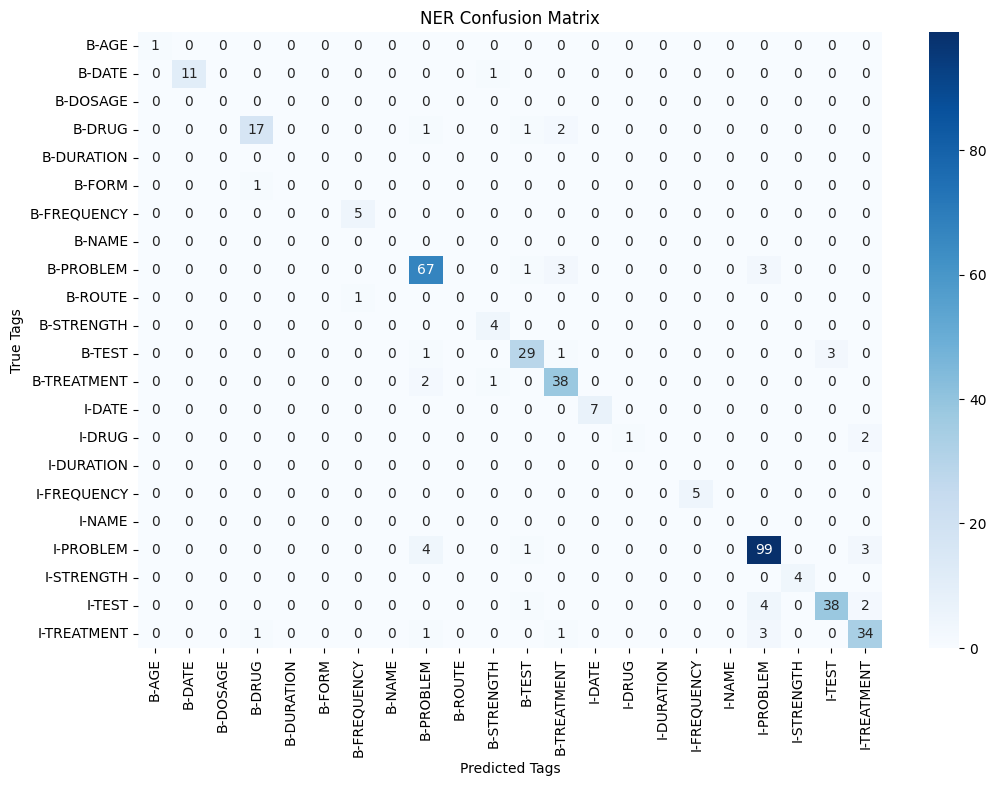


Classification Report (Excluding 'O' labels):
              precision    recall  f1-score   support

       B-AGE       1.00      0.50      0.67         2
      B-DATE       1.00      0.79      0.88        14
    B-DOSAGE       0.00      0.00      0.00         1
      B-DRUG       0.89      0.77      0.83        22
  B-DURATION       0.00      0.00      0.00         4
      B-FORM       0.00      0.00      0.00         1
 B-FREQUENCY       0.83      1.00      0.91         5
      B-NAME       0.00      0.00      0.00         2
   B-PROBLEM       0.83      0.83      0.83        81
     B-ROUTE       0.00      0.00      0.00         1
  B-STRENGTH       0.67      0.80      0.73         5
      B-TEST       0.81      0.81      0.81        36
 B-TREATMENT       0.76      0.76      0.76        50
      I-DATE       1.00      1.00      1.00         7
      I-DRUG       1.00      0.25      0.40         4
  I-DURATION       0.00      0.00      0.00         5
 I-FREQUENCY       1.00      1.00 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# First create the aligned DataFrame using Spark
aligned_df = predictions.select(
    F.explode(
        F.arrays_zip(
            F.col("ner"),
            F.col("label")
        )
    ).alias("cols"))\
    .select(
        F.expr("cols.ner.result").alias("ner_result"),
        F.expr("cols.label.result").alias("label_result"),
        F.expr("cols.ner.metadata.word").alias("word"))

# Collect the Spark DataFrame to Pandas
pdf = aligned_df.toPandas()

# Collect all tags
all_ner_tags = pdf['ner_result'].tolist()
all_label_tags = pdf['label_result'].tolist()

# Verify lengths match
print(f"Total NER tags: {len(all_ner_tags)}")
print(f"Total Label tags: {len(all_label_tags)}")

# Get unique labels excluding 'O'
unique_labels = sorted(set(all_ner_tags + all_label_tags) - {'O'})

# Create confusion matrix
cm = confusion_matrix(all_label_tags, all_ner_tags, labels=unique_labels)

# Visualize confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=unique_labels,
            yticklabels=unique_labels,
            cmap="Blues")
plt.title("NER Confusion Matrix")
plt.xlabel("Predicted Tags")
plt.ylabel("True Tags")
plt.show()

# Print classification report excluding 'O'
print("\nClassification Report (Excluding 'O' labels):")
print(classification_report(all_label_tags, all_ner_tags, labels=unique_labels))

####Observations from the Confusion Matrix:

High Performance Tags:
B-PROBLEM and I-PROBLEM: These tags perform well, with high precision and recall (e.g., B-PROBLEM has a recall of 0.90).
B-TEST and B-TREATMENT: Strong performance overall, though some misclassifications exist.
I-DATE and I-FREQUENCY: Both have excellent precision and recall, indicating reliable predictions.

Underperforming Tags:
B-DURATION, B-FORM, and B-NAME: These tags are rarely predicted correctly. Likely due to insufficient training data for these labels.
B-ROUTE: Completely unpredicted (zero recall), suggesting the model struggles with this entity.
I-DURATION: Similar issues as B-DURATION, likely due to limited training samples or challenging contextual dependencies.

Common Misclassifications:
B-TEST is occasionally confused with I-TEST and other tags like B-PROBLEM.
B-PROBLEM has minor overlaps with B-TREATMENT, indicating contextual ambiguities in distinguishing problems from treatments.
I-TREATMENT often misclassified as I-PROBLEM, highlighting challenges in differentiating continuation entities.
Insights from Classification Metrics:

Imbalanced Performance:
Entities like B-AGE, B-FORM, and B-DURATION suffer from low precision/recall due to rare occurrences in the dataset or model difficulties in identifying their unique features.
High-performing entities like B-TEST, B-TREATMENT, and I-PROBLEM dominate, pulling up the overall weighted average metrics.